# Visualiztaion & Interpretation of Surrogate Model
Objectives:
- Examine spatial and temporal behavior of predicted reservoir pressure using the surrogate model.
- Explore feature–target relationships to understand how geological and operational variables influence pressure dynamics.
- Assess predictive accuracy by comparing surrogate outputs against ground-truth simulation data.
- Produce 2D spatial visualizations, temporal evolution plots, and feature-based interpretations relevant to reservoir performance.
- Derive engineering insights for CCS performance, such as pressure containment efficiency, injection effects, and overall storage stability.


**Source:** Society of Petroleum Engineers (SPE)  
**Dataset:** SPE Comparative Solution Project - Model 11C (3D CO₂ Injection)

In [8]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay

import joblib
from tensorflow import keras
import shap

sns.set(style="whitegrid", rc={"figure.dpi": 100})

In [ ]:
PROCESSED = Path(r"C:\Users\tetec\Documents\Data Project Coding\.vscode\Project data\spe11c\data\processed")
MODELS = Path(r"C:\Users\tetec\Documents\Data Project Coding\.vscode\Project data\spe11c\models")

X = np.load(PROCESSED / "X.npy")
y = np.load(PROCESSED / "y.npy")

X_train_scaled = np.load(PROCESSED / "X_train_scaled.npy")
X_test_scaled  = np.load(PROCESSED / "X_test_scaled.npy")

y_train = np.load(PROCESSED / "y_train.npy")
y_test  = np.load(PROCESSED / "y_test.npy")

y_scaler = joblib.load(MODELS / "y_scaler.pkl")

mlp = keras.models.load_model(MODELS / "Surrogate_MLP.keras")

print("Data and model loaded successfully.")


Data and model loaded successfully.


In [ ]:
import joblib
from tensorflow.keras.models import load_model
import numpy as np

scaler_path = "models/feature_scaler.pkl"
yscaler_path = "models/y_scaler.pkl"
mlp_path = "models/Surrogate_MLP.keras"   

feature_scaler = joblib.load(scaler_path)
y_scaler = joblib.load(yscaler_path)

mlp = load_model(mlp_path)

In [11]:
class WrappedMLP:
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler

    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model.predict(X_scaled)

wrapped_mlp = WrappedMLP(mlp, feature_scaler)

In [12]:
feature_names = [
 " x [m]", "y [m]", "z [m]", "pressure [Pa]", "saturation [-]",
 "mCO2 [-]", "mH2O [-]", "rhoG [kg/m3]", "rhoL [kg/m3]",
 "tmCO2 [kg]", "temp [°C]",
 "depth_norm", "density_ratio", "co2_frac", "temp_dev",
 "p1 [Pa]_mean", "p1 [Pa]_max", "p1 [Pa]_last",
 "p2 [Pa]_mean", "p2 [Pa]_max", "p2 [Pa]_last",
 "mobA_mean", "mobA_max", "mobA_last",
 "immA_mean", "immA_max", "immA_last"
]

def invert_y(y_scaled):
    try:
        return y_scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()
    except Exception:
        return y_scaled

In [13]:
y_pred_scaled = wrapped_mlp.predict(X_test_scaled)
y_pred = invert_y(y_pred_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.4e}    R²: {r2:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test MSE: 1.3644e+09    R²: 0.9999


## 1. Parity Plot - Surrogate MLP

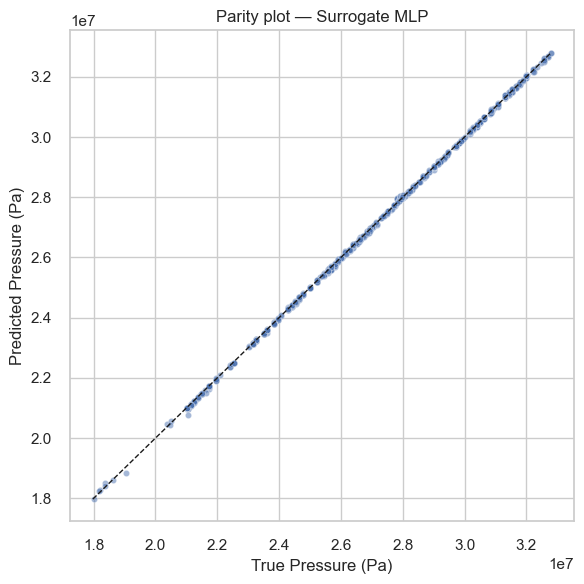

In [26]:
plt.figure(figsize=(6,6))
ax = plt.gca()
sns.scatterplot(x=y_test, y=y_pred, s=20, alpha=0.5)
mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
ax.plot([mn, mx], [mn, mx], 'k--', lw=1)
ax.set_xlabel("True Pressure (Pa)")
ax.set_ylabel("Predicted Pressure (Pa)")
ax.set_title("Parity plot — Surrogate MLP")
plt.tight_layout()
plt.savefig("parity_surrogate.png", dpi=300, bbox_inches="tight")
plt.show()

## 2. Residual Histogram

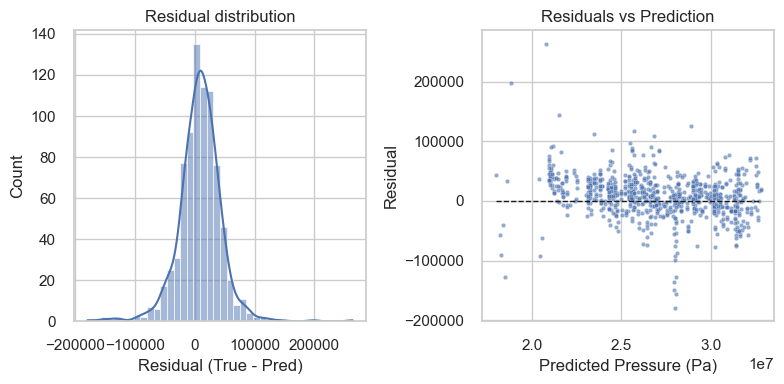

In [27]:
residuals = y_test - y_pred
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.histplot(residuals, bins=40, kde=True)
plt.xlabel("Residual (True - Pred)")
plt.title("Residual distribution")
plt.subplot(1,2,2)
sns.scatterplot(x=y_pred, y=residuals, s=10, alpha=0.6)
plt.hlines(0, xmin=y_pred.min(), xmax=y_pred.max(), colors='k', linestyles='dashed', linewidth=1)
plt.xlabel("Predicted Pressure (Pa)")
plt.ylabel("Residual")
plt.title("Residuals vs Prediction")
plt.tight_layout()
plt.savefig("residuals_surrogate.png", dpi=300, bbox_inches="tight")
plt.show()

In [20]:
from tensorflow.keras.models import load_model
mlp = load_model("models/Surrogate_MLP.keras", compile=False)

In [ ]:
import shap
import numpy as np

background = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 120, replace=False)]

expl = shap.Explainer(wrapped_mlp.predict, background, feature_names=feature_names)

shap_values = expl(X_test_scaled[:600])

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━

PermutationExplainer explainer:   0%|          | 3/600 [00:00<?, ?it/s]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 5/600 [00:15<19:49,  2.00s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 6/600 [00:19<28:39,  2.89s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|          | 7/600 [00:23<32:55,  3.33s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|▏         | 8/600 [00:27<34:48,  3.53s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   2%|▏         | 9/600 [00:31<35:49,  3.64s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   2%|▏         | 10/600 [00:35<36:05,  3.67s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   2%|▏         | 11/600 [00:39<37:16,  3.80s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   2%|▏         | 12/600 [00:43<37:20,  3.81s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   2%|▏         | 13/600 [00:47<37:28,  3.83s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   2%|▏         | 14/600 [00:50<37:17,  3.82s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   2%|▎         | 15/600 [00:54<36:59,  3.79s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   3%|▎         | 16/600 [00:58<37:31,  3.86s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   3%|▎         | 17/600 [01:02<37:56,  3.90s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   3%|▎         | 18/600 [01:06<37:39,  3.88s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   3%|▎         | 19/600 [01:10<37:51,  3.91s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   3%|▎         | 20/600 [01:14<37:39,  3.90s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   4%|▎         | 21/600 [01:18<37:27,  3.88s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   4%|▎         | 22/600 [01:22<37:35,  3.90s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   4%|▍         | 23/600 [01:26<38:31,  4.01s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   4%|▍         | 24/600 [01:30<38:21,  4.00s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   4%|▍         | 25/600 [01:34<38:36,  4.03s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   4%|▍         | 26/600 [01:38<38:11,  3.99s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   4%|▍         | 27/600 [01:42<37:54,  3.97s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   5%|▍         | 28/600 [01:46<37:55,  3.98s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   5%|▍         | 29/600 [01:50<37:53,  3.98s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   5%|▌         | 30/600 [01:54<38:18,  4.03s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   5%|▌         | 31/600 [01:58<38:26,  4.05s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   5%|▌         | 32/600 [02:02<37:56,  4.01s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   6%|▌         | 33/600 [02:06<37:47,  4.00s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   6%|▌         | 34/600 [02:10<38:29,  4.08s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   6%|▌         | 35/600 [02:14<38:55,  4.13s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   6%|▌         | 36/600 [02:18<38:30,  4.10s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   6%|▌         | 37/600 [02:22<38:09,  4.07s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   6%|▋         | 38/600 [02:26<37:37,  4.02s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   6%|▋         | 39/600 [02:30<37:07,  3.97s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   7%|▋         | 40/600 [02:34<37:22,  4.01s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   7%|▋         | 41/600 [02:38<37:07,  3.98s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   7%|▋         | 42/600 [02:42<37:01,  3.98s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   7%|▋         | 43/600 [02:46<36:48,  3.97s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   7%|▋         | 44/600 [02:50<36:29,  3.94s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   8%|▊         | 45/600 [02:54<36:33,  3.95s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   8%|▊         | 46/600 [02:58<37:08,  4.02s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   8%|▊         | 47/600 [03:02<36:29,  3.96s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   8%|▊         | 48/600 [03:06<36:25,  3.96s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   8%|▊         | 49/600 [03:10<36:11,  3.94s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   8%|▊         | 50/600 [03:14<35:48,  3.91s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   8%|▊         | 51/600 [03:18<35:48,  3.91s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   9%|▊         | 52/600 [03:21<35:47,  3.92s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   9%|▉         | 53/600 [03:25<36:01,  3.95s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   9%|▉         | 54/600 [03:29<35:20,  3.88s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   9%|▉         | 55/600 [03:34<36:31,  4.02s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   9%|▉         | 56/600 [03:38<36:21,  4.01s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  10%|▉         | 57/600 [03:41<36:06,  3.99s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  10%|▉         | 58/600 [03:46<37:29,  4.15s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  10%|▉         | 59/600 [03:50<36:52,  4.09s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  10%|█         | 60/600 [03:54<37:35,  4.18s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  10%|█         | 61/600 [03:58<37:11,  4.14s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  10%|█         | 62/600 [04:02<36:44,  4.10s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  10%|█         | 63/600 [04:06<35:51,  4.01s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  11%|█         | 64/600 [04:10<35:52,  4.02s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  11%|█         | 65/600 [04:14<35:02,  3.93s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  11%|█         | 66/600 [04:18<35:13,  3.96s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  11%|█         | 67/600 [04:22<35:05,  3.95s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  11%|█▏        | 68/600 [04:26<34:39,  3.91s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  12%|█▏        | 69/600 [04:30<34:20,  3.88s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  12%|█▏        | 70/600 [04:33<33:57,  3.84s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  12%|█▏        | 71/600 [04:37<33:49,  3.84s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  12%|█▏        | 72/600 [04:41<34:09,  3.88s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  12%|█▏        | 73/600 [04:45<33:51,  3.86s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  12%|█▏        | 74/600 [04:49<33:59,  3.88s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  12%|█▎        | 75/600 [04:53<33:56,  3.88s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  13%|█▎        | 76/600 [04:57<33:51,  3.88s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  13%|█▎        | 77/600 [05:00<33:41,  3.86s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  13%|█▎        | 78/600 [05:04<33:58,  3.91s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  13%|█▎        | 79/600 [05:09<34:59,  4.03s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  13%|█▎        | 80/600 [05:13<35:36,  4.11s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  14%|█▎        | 81/600 [05:17<36:13,  4.19s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  14%|█▎        | 82/600 [05:21<35:08,  4.07s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  14%|█▍        | 83/600 [05:25<34:35,  4.01s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  14%|█▍        | 84/600 [05:29<34:10,  3.97s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  14%|█▍        | 85/600 [05:33<33:55,  3.95s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  14%|█▍        | 86/600 [05:37<34:00,  3.97s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  14%|█▍        | 87/600 [05:41<33:25,  3.91s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  15%|█▍        | 88/600 [05:44<33:12,  3.89s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  15%|█▍        | 89/600 [05:48<33:06,  3.89s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  15%|█▌        | 90/600 [05:52<32:55,  3.87s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  15%|█▌        | 91/600 [05:56<32:51,  3.87s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  15%|█▌        | 92/600 [06:00<32:53,  3.89s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  16%|█▌        | 93/600 [06:04<32:59,  3.90s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  16%|█▌        | 94/600 [06:08<32:59,  3.91s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  16%|█▌        | 95/600 [06:12<32:22,  3.85s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  16%|█▌        | 96/600 [06:16<32:36,  3.88s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  16%|█▌        | 97/600 [06:19<32:23,  3.86s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  16%|█▋        | 98/600 [06:23<32:36,  3.90s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  16%|█▋        | 99/600 [06:27<32:29,  3.89s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  17%|█▋        | 100/600 [06:31<32:40,  3.92s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  17%|█▋        | 101/600 [06:35<32:22,  3.89s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  17%|█▋        | 102/600 [06:39<32:13,  3.88s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  17%|█▋        | 103/600 [06:43<32:22,  3.91s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  17%|█▋        | 104/600 [06:47<32:28,  3.93s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  18%|█▊        | 105/600 [06:51<32:15,  3.91s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  18%|█▊        | 106/600 [06:55<32:32,  3.95s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  18%|█▊        | 107/600 [06:59<32:12,  3.92s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  18%|█▊        | 108/600 [07:03<32:21,  3.95s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  18%|█▊        | 109/600 [07:07<32:12,  3.94s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  18%|█▊        | 110/600 [07:10<31:56,  3.91s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  18%|█▊        | 111/600 [07:14<31:47,  3.90s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  19%|█▊        | 112/600 [07:18<31:56,  3.93s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  19%|█▉        | 113/600 [07:22<32:16,  3.98s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  19%|█▉        | 114/600 [07:26<32:07,  3.97s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  19%|█▉        | 115/600 [07:30<31:55,  3.95s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  19%|█▉        | 116/600 [07:34<32:14,  4.00s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  20%|█▉        | 117/600 [07:38<31:26,  3.91s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  20%|█▉        | 118/600 [07:42<31:50,  3.96s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  20%|█▉        | 119/600 [07:46<31:40,  3.95s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  20%|██        | 120/600 [07:50<31:24,  3.93s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  20%|██        | 121/600 [07:54<32:03,  4.02s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  20%|██        | 122/600 [07:58<31:39,  3.97s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  20%|██        | 123/600 [08:02<31:20,  3.94s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  21%|██        | 124/600 [08:06<31:21,  3.95s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  21%|██        | 125/600 [08:10<31:25,  3.97s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  21%|██        | 126/600 [08:14<31:10,  3.95s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  21%|██        | 127/600 [08:18<30:51,  3.91s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  21%|██▏       | 128/600 [08:22<30:54,  3.93s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  22%|██▏       | 129/600 [08:25<30:40,  3.91s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  22%|██▏       | 130/600 [08:29<30:27,  3.89s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  22%|██▏       | 131/600 [08:33<29:55,  3.83s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  22%|██▏       | 132/600 [08:37<29:58,  3.84s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  22%|██▏       | 133/600 [08:41<29:48,  3.83s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  22%|██▏       | 134/600 [08:44<29:49,  3.84s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  22%|██▎       | 135/600 [08:48<29:45,  3.84s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  23%|██▎       | 136/600 [08:52<29:31,  3.82s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  23%|██▎       | 137/600 [08:56<30:06,  3.90s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  23%|██▎       | 138/600 [09:00<30:44,  3.99s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  23%|██▎       | 139/600 [09:04<30:25,  3.96s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  23%|██▎       | 140/600 [09:08<30:18,  3.95s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  24%|██▎       | 141/600 [09:12<30:14,  3.95s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  24%|██▎       | 142/600 [09:16<30:34,  4.00s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  24%|██▍       | 143/600 [09:20<30:14,  3.97s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  24%|██▍       | 144/600 [09:24<29:41,  3.91s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  24%|██▍       | 145/600 [09:28<30:07,  3.97s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  24%|██▍       | 146/600 [09:32<29:51,  3.95s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  24%|██▍       | 147/600 [09:36<30:12,  4.00s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  25%|██▍       | 148/600 [09:41<31:21,  4.16s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  25%|██▍       | 149/600 [09:45<31:06,  4.14s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  25%|██▌       | 150/600 [09:49<31:27,  4.19s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  25%|██▌       | 151/600 [09:53<30:54,  4.13s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  25%|██▌       | 152/600 [09:57<30:08,  4.04s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  26%|██▌       | 153/600 [10:01<30:08,  4.05s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  26%|██▌       | 154/600 [10:05<29:31,  3.97s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  26%|██▌       | 155/600 [10:09<29:44,  4.01s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  26%|██▌       | 156/600 [10:13<29:32,  3.99s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  26%|██▌       | 157/600 [10:17<29:34,  4.01s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  26%|██▋       | 158/600 [10:21<29:07,  3.95s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  26%|██▋       | 159/600 [10:24<28:55,  3.94s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  27%|██▋       | 160/600 [10:29<29:12,  3.98s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  27%|██▋       | 161/600 [10:33<30:01,  4.10s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  27%|██▋       | 162/600 [10:37<30:13,  4.14s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  27%|██▋       | 163/600 [10:41<30:30,  4.19s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  27%|██▋       | 164/600 [10:45<30:03,  4.14s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  28%|██▊       | 165/600 [10:50<30:39,  4.23s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  28%|██▊       | 166/600 [10:54<30:21,  4.20s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  28%|██▊       | 167/600 [10:58<29:42,  4.12s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  28%|██▊       | 168/600 [11:02<29:17,  4.07s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  28%|██▊       | 169/600 [11:06<29:03,  4.05s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  28%|██▊       | 170/600 [11:10<28:40,  4.00s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  28%|██▊       | 171/600 [11:14<28:10,  3.94s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  29%|██▊       | 172/600 [11:18<28:08,  3.94s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  29%|██▉       | 173/600 [11:21<27:57,  3.93s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  29%|██▉       | 174/600 [11:25<27:51,  3.92s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  29%|██▉       | 175/600 [11:29<28:11,  3.98s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  29%|██▉       | 176/600 [11:34<28:21,  4.01s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  30%|██▉       | 177/600 [11:38<28:29,  4.04s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  30%|██▉       | 178/600 [11:42<28:27,  4.05s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  30%|██▉       | 179/600 [11:46<28:09,  4.01s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  30%|███       | 180/600 [11:50<28:00,  4.00s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  30%|███       | 181/600 [11:54<28:24,  4.07s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  30%|███       | 182/600 [11:58<28:21,  4.07s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  30%|███       | 183/600 [12:02<28:22,  4.08s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  31%|███       | 184/600 [12:06<27:52,  4.02s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  31%|███       | 185/600 [12:10<27:35,  3.99s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  31%|███       | 186/600 [12:14<27:43,  4.02s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  31%|███       | 187/600 [12:18<27:41,  4.02s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  31%|███▏      | 188/600 [12:22<27:31,  4.01s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  32%|███▏      | 189/600 [12:26<27:13,  3.97s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  32%|███▏      | 190/600 [12:30<27:39,  4.05s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  32%|███▏      | 191/600 [12:34<27:29,  4.03s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  32%|███▏      | 192/600 [12:38<27:21,  4.02s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  32%|███▏      | 193/600 [12:42<27:03,  3.99s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  32%|███▏      | 194/600 [12:46<27:10,  4.02s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  32%|███▎      | 195/600 [12:50<26:59,  4.00s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  33%|███▎      | 196/600 [12:54<27:03,  4.02s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  33%|███▎      | 197/600 [12:58<26:32,  3.95s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  33%|███▎      | 198/600 [13:02<26:41,  3.98s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  33%|███▎      | 199/600 [13:06<27:28,  4.11s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  33%|███▎      | 200/600 [13:10<27:16,  4.09s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  34%|███▎      | 201/600 [13:14<27:11,  4.09s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  34%|███▎      | 202/600 [13:18<26:28,  3.99s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  34%|███▍      | 203/600 [13:22<26:15,  3.97s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  34%|███▍      | 204/600 [13:26<26:05,  3.95s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  34%|███▍      | 205/600 [13:30<26:00,  3.95s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  34%|███▍      | 206/600 [13:34<26:34,  4.05s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  34%|███▍      | 207/600 [13:38<26:26,  4.04s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  35%|███▍      | 208/600 [13:42<26:31,  4.06s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  35%|███▍      | 209/600 [13:46<26:04,  4.00s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  35%|███▌      | 210/600 [13:50<25:47,  3.97s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  35%|███▌      | 211/600 [13:54<26:18,  4.06s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  35%|███▌      | 212/600 [13:58<26:12,  4.05s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  36%|███▌      | 213/600 [14:03<26:09,  4.05s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  36%|███▌      | 214/600 [14:07<26:20,  4.10s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  36%|███▌      | 215/600 [14:11<25:52,  4.03s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  36%|███▌      | 216/600 [14:15<25:55,  4.05s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  36%|███▌      | 217/600 [14:19<25:40,  4.02s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  36%|███▋      | 218/600 [14:23<25:47,  4.05s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  36%|███▋      | 219/600 [14:27<25:50,  4.07s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  37%|███▋      | 220/600 [14:31<25:36,  4.04s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  37%|███▋      | 221/600 [14:35<25:36,  4.05s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  37%|███▋      | 222/600 [14:39<25:24,  4.03s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  37%|███▋      | 223/600 [14:43<25:32,  4.07s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  37%|███▋      | 224/600 [14:47<25:25,  4.06s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  38%|███▊      | 225/600 [14:51<24:51,  3.98s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  38%|███▊      | 226/600 [14:55<25:09,  4.04s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  38%|███▊      | 227/600 [14:59<25:16,  4.07s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  38%|███▊      | 228/600 [15:03<25:03,  4.04s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  38%|███▊      | 229/600 [15:07<25:04,  4.06s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  38%|███▊      | 230/600 [15:11<24:51,  4.03s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  38%|███▊      | 231/600 [15:15<24:50,  4.04s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  39%|███▊      | 232/600 [15:19<24:59,  4.07s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  39%|███▉      | 233/600 [15:24<24:53,  4.07s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  39%|███▉      | 234/600 [15:28<25:17,  4.15s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  39%|███▉      | 235/600 [15:32<25:13,  4.15s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  39%|███▉      | 236/600 [15:36<24:41,  4.07s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  40%|███▉      | 237/600 [15:40<25:23,  4.20s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  40%|███▉      | 238/600 [15:44<25:06,  4.16s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  40%|███▉      | 239/600 [15:49<25:09,  4.18s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  40%|████      | 240/600 [15:53<24:42,  4.12s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  40%|████      | 241/600 [15:57<24:55,  4.17s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  40%|████      | 242/600 [16:01<25:02,  4.20s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  40%|████      | 243/600 [16:06<25:36,  4.31s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  41%|████      | 244/600 [16:10<25:45,  4.34s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  41%|████      | 245/600 [16:14<25:31,  4.31s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  41%|████      | 246/600 [16:19<25:27,  4.32s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  41%|████      | 247/600 [16:23<25:36,  4.35s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  41%|████▏     | 248/600 [16:28<25:48,  4.40s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  42%|████▏     | 249/600 [16:32<25:28,  4.36s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  42%|████▏     | 250/600 [16:36<25:19,  4.34s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  42%|████▏     | 251/600 [16:40<25:01,  4.30s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  42%|████▏     | 252/600 [16:46<26:31,  4.57s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  42%|████▏     | 253/600 [16:50<26:37,  4.60s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  42%|████▏     | 254/600 [16:54<25:42,  4.46s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  42%|████▎     | 255/600 [16:58<24:29,  4.26s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  43%|████▎     | 256/600 [17:02<23:33,  4.11s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  43%|████▎     | 257/600 [17:06<23:03,  4.03s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  43%|████▎     | 258/600 [17:10<22:47,  4.00s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  43%|████▎     | 259/600 [17:14<22:32,  3.97s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  43%|████▎     | 260/600 [17:17<21:42,  3.83s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  44%|████▎     | 261/600 [17:21<21:06,  3.74s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  44%|████▎     | 262/600 [17:25<21:11,  3.76s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  44%|████▍     | 263/600 [17:29<22:00,  3.92s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  44%|████▍     | 264/600 [17:33<22:02,  3.94s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  44%|████▍     | 265/600 [17:37<22:01,  3.94s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  44%|████▍     | 266/600 [17:40<21:25,  3.85s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  44%|████▍     | 267/600 [17:44<20:49,  3.75s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  45%|████▍     | 268/600 [17:47<20:26,  3.69s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  45%|████▍     | 269/600 [17:51<20:08,  3.65s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  45%|████▌     | 270/600 [17:55<20:36,  3.75s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  45%|████▌     | 271/600 [17:59<20:23,  3.72s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  45%|████▌     | 272/600 [18:02<19:49,  3.63s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  46%|████▌     | 273/600 [18:06<19:34,  3.59s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  46%|████▌     | 274/600 [18:10<20:27,  3.76s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  46%|████▌     | 275/600 [18:14<20:37,  3.81s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  46%|████▌     | 276/600 [18:18<21:07,  3.91s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  46%|████▌     | 277/600 [18:22<20:44,  3.85s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  46%|████▋     | 278/600 [18:25<20:38,  3.85s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  46%|████▋     | 279/600 [18:30<21:21,  3.99s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  47%|████▋     | 280/600 [18:34<21:16,  3.99s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  47%|████▋     | 281/600 [18:37<20:27,  3.85s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  47%|████▋     | 282/600 [18:41<19:52,  3.75s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  47%|████▋     | 283/600 [18:45<20:24,  3.86s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  47%|████▋     | 284/600 [18:49<20:48,  3.95s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  48%|████▊     | 285/600 [18:54<21:45,  4.14s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  48%|████▊     | 286/600 [18:57<20:37,  3.94s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  48%|████▊     | 287/600 [19:01<19:48,  3.80s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  48%|████▊     | 288/600 [19:04<19:25,  3.73s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  48%|████▊     | 289/600 [19:08<19:35,  3.78s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  48%|████▊     | 290/600 [19:12<19:52,  3.85s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  48%|████▊     | 291/600 [19:16<19:15,  3.74s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  49%|████▊     | 292/600 [19:19<18:50,  3.67s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  49%|████▉     | 293/600 [19:23<18:53,  3.69s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  49%|████▉     | 294/600 [19:26<18:26,  3.62s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  49%|████▉     | 295/600 [19:30<18:48,  3.70s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  49%|████▉     | 296/600 [19:34<18:31,  3.66s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  50%|████▉     | 297/600 [19:37<18:43,  3.71s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  50%|████▉     | 298/600 [19:41<18:41,  3.72s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  50%|████▉     | 299/600 [19:45<18:31,  3.69s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  50%|█████     | 300/600 [19:49<18:44,  3.75s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  50%|█████     | 301/600 [19:52<18:20,  3.68s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  50%|█████     | 302/600 [19:56<18:14,  3.67s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  50%|█████     | 303/600 [20:00<18:11,  3.67s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  51%|█████     | 304/600 [20:03<18:09,  3.68s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  51%|█████     | 305/600 [20:07<18:10,  3.70s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  51%|█████     | 306/600 [20:11<18:13,  3.72s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  51%|█████     | 307/600 [20:15<18:19,  3.75s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  51%|█████▏    | 308/600 [20:18<18:09,  3.73s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  52%|█████▏    | 309/600 [20:22<18:14,  3.76s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  52%|█████▏    | 310/600 [20:26<18:19,  3.79s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  52%|█████▏    | 311/600 [20:31<19:19,  4.01s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  52%|█████▏    | 312/600 [20:35<19:22,  4.04s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  52%|█████▏    | 313/600 [20:38<18:52,  3.95s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  52%|█████▏    | 314/600 [20:42<18:50,  3.95s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  52%|█████▎    | 315/600 [20:46<18:22,  3.87s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  53%|█████▎    | 316/600 [20:50<17:49,  3.77s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  53%|█████▎    | 317/600 [20:53<17:08,  3.63s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  53%|█████▎    | 318/600 [20:56<16:45,  3.56s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  53%|█████▎    | 319/600 [21:00<16:39,  3.56s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  53%|█████▎    | 320/600 [21:03<16:31,  3.54s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  54%|█████▎    | 321/600 [21:07<16:18,  3.51s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  54%|█████▎    | 322/600 [21:10<16:21,  3.53s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  54%|█████▍    | 323/600 [21:14<17:07,  3.71s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  54%|█████▍    | 324/600 [21:18<17:33,  3.82s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  54%|█████▍    | 325/600 [21:22<16:56,  3.69s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  54%|█████▍    | 326/600 [21:26<17:03,  3.73s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  55%|█████▍    | 327/600 [21:29<16:56,  3.72s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  55%|█████▍    | 328/600 [21:33<16:53,  3.73s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  55%|█████▍    | 329/600 [21:37<17:19,  3.84s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  55%|█████▌    | 330/600 [21:41<17:35,  3.91s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  55%|█████▌    | 331/600 [21:45<17:19,  3.86s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  55%|█████▌    | 332/600 [21:49<17:15,  3.86s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  56%|█████▌    | 333/600 [21:53<17:07,  3.85s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  56%|█████▌    | 334/600 [21:57<17:39,  3.98s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  56%|█████▌    | 335/600 [22:00<16:51,  3.82s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  56%|█████▌    | 336/600 [22:04<16:17,  3.70s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  56%|█████▌    | 337/600 [22:07<16:03,  3.67s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  56%|█████▋    | 338/600 [22:11<15:29,  3.55s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  56%|█████▋    | 339/600 [22:14<15:35,  3.58s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  57%|█████▋    | 340/600 [22:18<15:16,  3.52s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  57%|█████▋    | 341/600 [22:21<15:12,  3.52s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  57%|█████▋    | 342/600 [22:25<15:01,  3.49s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  57%|█████▋    | 343/600 [22:28<14:51,  3.47s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  57%|█████▋    | 344/600 [22:32<14:38,  3.43s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  57%|█████▊    | 345/600 [22:35<14:32,  3.42s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  58%|█████▊    | 346/600 [22:38<14:21,  3.39s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  58%|█████▊    | 347/600 [22:42<14:14,  3.38s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  58%|█████▊    | 348/600 [22:45<14:18,  3.41s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  58%|█████▊    | 349/600 [22:49<14:40,  3.51s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  58%|█████▊    | 350/600 [22:52<14:36,  3.50s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  58%|█████▊    | 351/600 [22:56<14:28,  3.49s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  59%|█████▊    | 352/600 [22:59<14:41,  3.55s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  59%|█████▉    | 353/600 [23:03<14:46,  3.59s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  59%|█████▉    | 354/600 [23:07<14:49,  3.61s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  59%|█████▉    | 355/600 [23:10<14:33,  3.57s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  59%|█████▉    | 356/600 [23:14<14:29,  3.56s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  60%|█████▉    | 357/600 [23:17<14:15,  3.52s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  60%|█████▉    | 358/600 [23:21<14:11,  3.52s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  60%|█████▉    | 359/600 [23:24<14:03,  3.50s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  60%|██████    | 360/600 [23:28<14:51,  3.72s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  60%|██████    | 361/600 [23:32<14:23,  3.61s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  60%|██████    | 362/600 [23:35<14:01,  3.53s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  60%|██████    | 363/600 [23:39<13:51,  3.51s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  61%|██████    | 364/600 [23:42<13:52,  3.53s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  61%|██████    | 365/600 [23:46<13:45,  3.51s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  61%|██████    | 366/600 [23:49<13:47,  3.54s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  61%|██████    | 367/600 [23:53<13:37,  3.51s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  61%|██████▏   | 368/600 [23:56<13:45,  3.56s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  62%|██████▏   | 369/600 [24:00<13:36,  3.54s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  62%|██████▏   | 370/600 [24:03<13:35,  3.55s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  62%|██████▏   | 371/600 [24:07<13:21,  3.50s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  62%|██████▏   | 372/600 [24:10<13:19,  3.50s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  62%|██████▏   | 373/600 [24:14<13:11,  3.49s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  62%|██████▏   | 374/600 [24:17<13:10,  3.50s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  62%|██████▎   | 375/600 [24:21<13:14,  3.53s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  63%|██████▎   | 376/600 [24:24<13:15,  3.55s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  63%|██████▎   | 377/600 [24:28<13:20,  3.59s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  63%|██████▎   | 378/600 [24:32<13:30,  3.65s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  63%|██████▎   | 379/600 [24:36<13:39,  3.71s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  63%|██████▎   | 380/600 [24:40<13:35,  3.71s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  64%|██████▎   | 381/600 [24:43<13:24,  3.67s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  64%|██████▎   | 382/600 [24:47<13:04,  3.60s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  64%|██████▍   | 383/600 [24:50<12:52,  3.56s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  64%|██████▍   | 384/600 [24:53<12:33,  3.49s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  64%|██████▍   | 385/600 [24:57<12:45,  3.56s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  64%|██████▍   | 386/600 [25:01<12:51,  3.60s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  64%|██████▍   | 387/600 [25:04<12:37,  3.56s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  65%|██████▍   | 388/600 [25:08<12:34,  3.56s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  65%|██████▍   | 389/600 [25:11<12:39,  3.60s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  65%|██████▌   | 390/600 [25:15<12:46,  3.65s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  65%|██████▌   | 391/600 [25:20<14:15,  4.09s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  65%|██████▌   | 392/600 [25:24<13:40,  3.95s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  66%|██████▌   | 393/600 [25:28<13:19,  3.86s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  66%|██████▌   | 394/600 [25:31<13:12,  3.85s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  66%|██████▌   | 395/600 [25:35<12:58,  3.80s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  66%|██████▌   | 396/600 [25:39<12:54,  3.79s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  66%|██████▌   | 397/600 [25:42<12:33,  3.71s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  66%|██████▋   | 398/600 [25:46<12:23,  3.68s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  66%|██████▋   | 399/600 [25:49<12:02,  3.60s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  67%|██████▋   | 400/600 [25:53<11:49,  3.55s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  67%|██████▋   | 401/600 [25:56<11:43,  3.53s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  67%|██████▋   | 402/600 [26:00<11:43,  3.55s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  67%|██████▋   | 403/600 [26:04<11:49,  3.60s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  67%|██████▋   | 404/600 [26:08<12:06,  3.71s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  68%|██████▊   | 405/600 [26:12<12:13,  3.76s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  68%|██████▊   | 406/600 [26:16<13:02,  4.04s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  68%|██████▊   | 407/600 [26:22<14:29,  4.50s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  68%|██████▊   | 408/600 [26:28<15:56,  4.98s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  68%|██████▊   | 409/600 [26:32<15:00,  4.72s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  68%|██████▊   | 410/600 [26:36<13:53,  4.39s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  68%|██████▊   | 411/600 [26:39<12:50,  4.07s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  69%|██████▊   | 412/600 [26:43<12:18,  3.93s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  69%|██████▉   | 413/600 [26:46<12:04,  3.87s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  69%|██████▉   | 414/600 [26:50<12:05,  3.90s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  69%|██████▉   | 415/600 [26:54<11:36,  3.76s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  69%|██████▉   | 416/600 [26:57<11:12,  3.65s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  70%|██████▉   | 417/600 [27:00<10:53,  3.57s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  70%|██████▉   | 418/600 [27:04<10:41,  3.52s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  70%|██████▉   | 419/600 [27:07<10:29,  3.48s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  70%|███████   | 420/600 [27:11<10:37,  3.54s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  70%|███████   | 421/600 [27:15<10:37,  3.56s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  70%|███████   | 422/600 [27:18<10:36,  3.58s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  70%|███████   | 423/600 [27:22<10:44,  3.64s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  71%|███████   | 424/600 [27:26<11:06,  3.79s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  71%|███████   | 425/600 [27:30<11:07,  3.82s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  71%|███████   | 426/600 [27:34<11:02,  3.81s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  71%|███████   | 427/600 [27:38<11:06,  3.85s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  71%|███████▏  | 428/600 [27:41<10:56,  3.82s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  72%|███████▏  | 429/600 [27:45<10:53,  3.82s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  72%|███████▏  | 430/600 [27:49<10:50,  3.83s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  72%|███████▏  | 431/600 [27:53<10:31,  3.74s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  72%|███████▏  | 432/600 [27:56<10:31,  3.76s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  72%|███████▏  | 433/600 [28:00<10:26,  3.75s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  72%|███████▏  | 434/600 [28:04<10:18,  3.73s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  72%|███████▎  | 435/600 [28:07<10:09,  3.70s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  73%|███████▎  | 436/600 [28:11<09:54,  3.63s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  73%|███████▎  | 437/600 [28:14<09:48,  3.61s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  73%|███████▎  | 438/600 [28:18<09:43,  3.60s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  73%|███████▎  | 439/600 [28:22<09:36,  3.58s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  73%|███████▎  | 440/600 [28:25<09:27,  3.55s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  74%|███████▎  | 441/600 [28:29<09:32,  3.60s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  74%|███████▎  | 442/600 [28:33<09:34,  3.64s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  74%|███████▍  | 443/600 [28:36<09:24,  3.60s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  74%|███████▍  | 444/600 [28:40<09:26,  3.63s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  74%|███████▍  | 445/600 [28:43<09:25,  3.65s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  74%|███████▍  | 446/600 [28:47<09:15,  3.61s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  74%|███████▍  | 447/600 [28:51<09:13,  3.62s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  75%|███████▍  | 448/600 [28:54<09:12,  3.63s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  75%|███████▍  | 449/600 [28:58<09:10,  3.65s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  75%|███████▌  | 450/600 [29:02<09:03,  3.62s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  75%|███████▌  | 451/600 [29:05<09:01,  3.63s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  75%|███████▌  | 452/600 [29:09<08:49,  3.58s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  76%|███████▌  | 453/600 [29:12<08:39,  3.53s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  76%|███████▌  | 454/600 [29:16<08:39,  3.56s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  76%|███████▌  | 455/600 [29:19<08:32,  3.54s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  76%|███████▌  | 456/600 [29:23<08:32,  3.56s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  76%|███████▌  | 457/600 [29:26<08:35,  3.60s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  76%|███████▋  | 458/600 [29:30<08:44,  3.69s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  76%|███████▋  | 459/600 [29:34<08:33,  3.64s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  77%|███████▋  | 460/600 [29:38<08:31,  3.65s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  77%|███████▋  | 461/600 [29:41<08:29,  3.67s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  77%|███████▋  | 462/600 [29:45<08:26,  3.67s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  77%|███████▋  | 463/600 [29:49<08:17,  3.63s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  77%|███████▋  | 464/600 [29:52<08:14,  3.64s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  78%|███████▊  | 465/600 [29:56<08:08,  3.62s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  78%|███████▊  | 466/600 [29:59<08:00,  3.59s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  78%|███████▊  | 467/600 [30:03<07:51,  3.54s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  78%|███████▊  | 468/600 [30:06<07:43,  3.51s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  78%|███████▊  | 469/600 [30:10<07:47,  3.57s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  78%|███████▊  | 470/600 [30:13<07:45,  3.58s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  78%|███████▊  | 471/600 [30:17<07:46,  3.61s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  79%|███████▊  | 472/600 [30:21<07:39,  3.59s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  79%|███████▉  | 473/600 [30:24<07:34,  3.58s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  79%|███████▉  | 474/600 [30:28<07:28,  3.56s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  79%|███████▉  | 475/600 [30:31<07:26,  3.58s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  79%|███████▉  | 476/600 [30:35<07:24,  3.58s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  80%|███████▉  | 477/600 [30:39<07:25,  3.62s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  80%|███████▉  | 478/600 [30:42<07:22,  3.63s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  80%|███████▉  | 479/600 [30:46<07:17,  3.61s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  80%|████████  | 480/600 [30:50<07:39,  3.83s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  80%|████████  | 481/600 [30:55<08:05,  4.08s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  80%|████████  | 482/600 [30:58<07:37,  3.88s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  80%|████████  | 483/600 [31:03<07:53,  4.05s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  81%|████████  | 484/600 [31:07<07:48,  4.04s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  81%|████████  | 485/600 [31:11<07:40,  4.00s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  81%|████████  | 486/600 [31:14<07:29,  3.94s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  81%|████████  | 487/600 [31:18<07:19,  3.89s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  81%|████████▏ | 488/600 [31:22<07:06,  3.81s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  82%|████████▏ | 489/600 [31:26<07:01,  3.80s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  82%|████████▏ | 490/600 [31:29<06:58,  3.81s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  82%|████████▏ | 491/600 [31:33<06:44,  3.71s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  82%|████████▏ | 492/600 [31:36<06:33,  3.64s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  82%|████████▏ | 493/600 [31:40<06:33,  3.68s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  82%|████████▏ | 494/600 [31:44<06:34,  3.72s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  82%|████████▎ | 495/600 [31:48<06:35,  3.77s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  83%|████████▎ | 496/600 [31:52<06:30,  3.76s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  83%|████████▎ | 497/600 [31:56<06:33,  3.82s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  83%|████████▎ | 498/600 [31:59<06:22,  3.75s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  83%|████████▎ | 499/600 [32:03<06:15,  3.72s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  83%|████████▎ | 500/600 [32:07<06:17,  3.78s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  84%|████████▎ | 501/600 [32:11<06:42,  4.07s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  84%|████████▎ | 502/600 [32:16<06:44,  4.13s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  84%|████████▍ | 503/600 [32:19<06:28,  4.01s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  84%|████████▍ | 504/600 [32:24<06:30,  4.07s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  84%|████████▍ | 505/600 [32:28<06:47,  4.29s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  84%|████████▍ | 506/600 [32:33<06:47,  4.33s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  84%|████████▍ | 507/600 [32:37<06:23,  4.12s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  85%|████████▍ | 508/600 [32:40<06:08,  4.01s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  85%|████████▍ | 509/600 [32:44<05:54,  3.90s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  85%|████████▌ | 510/600 [32:48<05:47,  3.86s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  85%|████████▌ | 511/600 [32:51<05:38,  3.81s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  85%|████████▌ | 512/600 [32:55<05:41,  3.88s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  86%|████████▌ | 513/600 [32:59<05:34,  3.85s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  86%|████████▌ | 514/600 [33:03<05:33,  3.88s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  86%|████████▌ | 515/600 [33:07<05:40,  4.00s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  86%|████████▌ | 516/600 [33:11<05:26,  3.89s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  86%|████████▌ | 517/600 [33:15<05:17,  3.82s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  86%|████████▋ | 518/600 [33:18<05:08,  3.76s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  86%|████████▋ | 519/600 [33:22<05:03,  3.75s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  87%|████████▋ | 520/600 [33:26<05:03,  3.79s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  87%|████████▋ | 521/600 [33:30<04:55,  3.74s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  87%|████████▋ | 522/600 [33:33<04:45,  3.66s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  87%|████████▋ | 523/600 [33:36<04:36,  3.59s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  87%|████████▋ | 524/600 [33:40<04:31,  3.57s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  88%|████████▊ | 525/600 [33:44<04:26,  3.56s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  88%|████████▊ | 526/600 [33:47<04:28,  3.63s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  88%|████████▊ | 527/600 [33:51<04:28,  3.67s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  88%|████████▊ | 528/600 [33:55<04:27,  3.71s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  88%|████████▊ | 529/600 [33:59<04:24,  3.72s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  88%|████████▊ | 530/600 [34:03<04:30,  3.86s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  88%|████████▊ | 531/600 [34:06<04:20,  3.78s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  89%|████████▊ | 532/600 [34:10<04:07,  3.65s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  89%|████████▉ | 533/600 [34:13<03:59,  3.57s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  89%|████████▉ | 534/600 [34:17<03:54,  3.56s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  89%|████████▉ | 535/600 [34:20<03:49,  3.54s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  89%|████████▉ | 536/600 [34:24<03:45,  3.52s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  90%|████████▉ | 537/600 [34:27<03:43,  3.54s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  90%|████████▉ | 538/600 [34:31<03:40,  3.56s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  90%|████████▉ | 539/600 [34:34<03:36,  3.54s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  90%|█████████ | 540/600 [34:38<03:35,  3.59s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  90%|█████████ | 541/600 [34:42<03:37,  3.68s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  90%|█████████ | 542/600 [34:46<03:40,  3.80s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  90%|█████████ | 543/600 [34:50<03:36,  3.79s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  91%|█████████ | 544/600 [34:54<03:32,  3.79s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  91%|█████████ | 545/600 [34:57<03:29,  3.80s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  91%|█████████ | 546/600 [35:01<03:24,  3.78s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  91%|█████████ | 547/600 [35:06<03:34,  4.04s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  91%|█████████▏| 548/600 [35:10<03:31,  4.07s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  92%|█████████▏| 549/600 [35:14<03:24,  4.01s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  92%|█████████▏| 550/600 [35:17<03:15,  3.90s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  92%|█████████▏| 551/600 [35:21<03:08,  3.84s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  92%|█████████▏| 552/600 [35:25<03:00,  3.76s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  92%|█████████▏| 553/600 [35:28<02:52,  3.66s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  92%|█████████▏| 554/600 [35:32<02:49,  3.69s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  92%|█████████▎| 555/600 [35:35<02:42,  3.61s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  93%|█████████▎| 556/600 [35:39<02:38,  3.60s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  93%|█████████▎| 557/600 [35:42<02:32,  3.55s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  93%|█████████▎| 558/600 [35:46<02:26,  3.50s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  93%|█████████▎| 559/600 [35:50<02:32,  3.71s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  93%|█████████▎| 560/600 [35:54<02:31,  3.79s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  94%|█████████▎| 561/600 [35:58<02:26,  3.75s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  94%|█████████▎| 562/600 [36:02<02:26,  3.84s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  94%|█████████▍| 563/600 [36:06<02:31,  4.09s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  94%|█████████▍| 564/600 [36:10<02:27,  4.11s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  94%|█████████▍| 565/600 [36:14<02:16,  3.89s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  94%|█████████▍| 566/600 [36:18<02:11,  3.85s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  94%|█████████▍| 567/600 [36:21<02:04,  3.77s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  95%|█████████▍| 568/600 [36:25<01:59,  3.72s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  95%|█████████▍| 569/600 [36:28<01:55,  3.72s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  95%|█████████▌| 570/600 [36:32<01:52,  3.74s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  95%|█████████▌| 571/600 [36:36<01:50,  3.79s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  95%|█████████▌| 572/600 [36:40<01:45,  3.77s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  96%|█████████▌| 573/600 [36:44<01:41,  3.77s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  96%|█████████▌| 574/600 [36:47<01:35,  3.67s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  96%|█████████▌| 575/600 [36:51<01:29,  3.60s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  96%|█████████▌| 576/600 [36:54<01:27,  3.66s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  96%|█████████▌| 577/600 [36:58<01:24,  3.66s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  96%|█████████▋| 578/600 [37:01<01:18,  3.58s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  96%|█████████▋| 579/600 [37:05<01:15,  3.58s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  97%|█████████▋| 580/600 [37:09<01:12,  3.61s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  97%|█████████▋| 581/600 [37:12<01:09,  3.65s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  97%|█████████▋| 582/600 [37:16<01:05,  3.62s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  97%|█████████▋| 583/600 [37:19<01:00,  3.56s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  97%|█████████▋| 584/600 [37:23<00:55,  3.48s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  98%|█████████▊| 585/600 [37:26<00:52,  3.48s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  98%|█████████▊| 586/600 [37:30<00:48,  3.47s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  98%|█████████▊| 587/600 [37:33<00:44,  3.46s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  98%|█████████▊| 588/600 [37:37<00:44,  3.72s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  98%|█████████▊| 589/600 [37:41<00:41,  3.81s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  98%|█████████▊| 590/600 [37:45<00:37,  3.79s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  98%|█████████▊| 591/600 [37:50<00:36,  4.11s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  99%|█████████▊| 592/600 [37:54<00:32,  4.07s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  99%|█████████▉| 593/600 [37:58<00:27,  3.98s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  99%|█████████▉| 594/600 [38:02<00:24,  4.05s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  99%|█████████▉| 595/600 [38:06<00:19,  3.91s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  99%|█████████▉| 596/600 [38:10<00:16,  4.05s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer: 100%|█████████▉| 597/600 [38:14<00:11,  3.99s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer: 100%|█████████▉| 598/600 [38:18<00:07,  3.97s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer: 100%|█████████▉| 599/600 [38:21<00:03,  3.87s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer: 100%|██████████| 600/600 [38:25<00:00,  3.86s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer: 601it [38:29,  3.86s/it]                         


## 3. Global SHAP-Based Feature Importance Evaluation

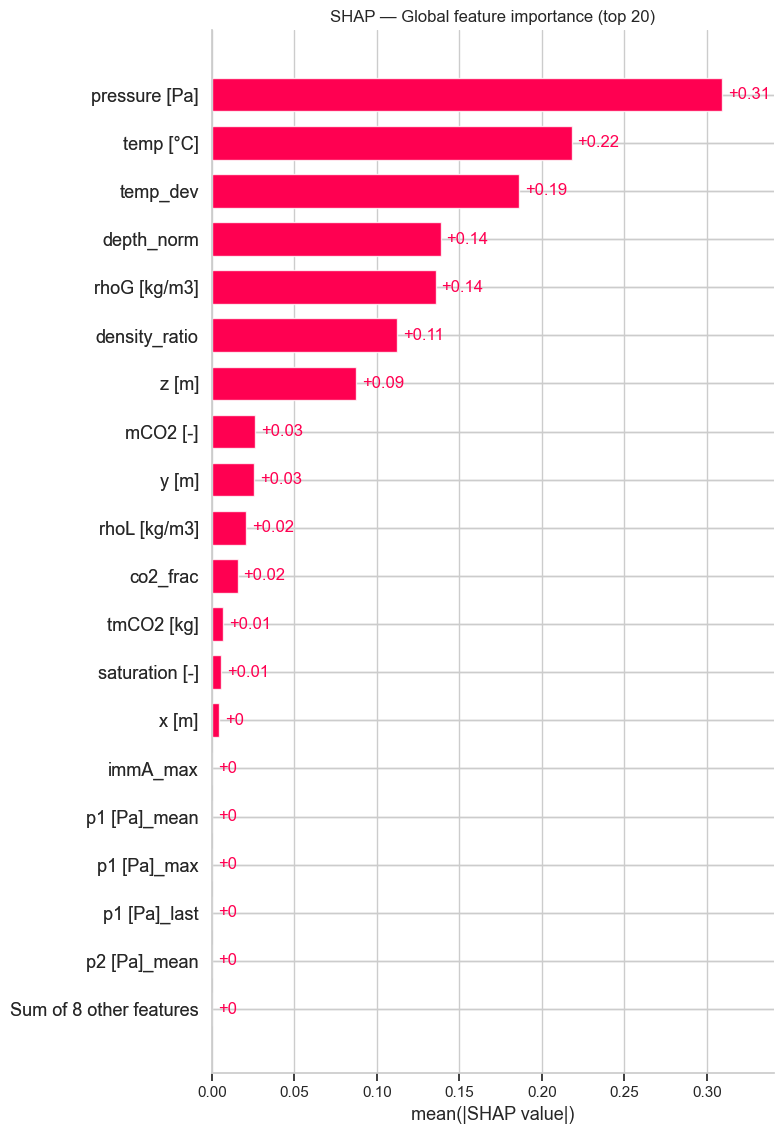

In [23]:
plt.figure(figsize=(8,6))
try:
    shap.plots.bar(shap_values, max_display=20, show=False)
except Exception:
    # fallback manual importance using mean absolute
    if isinstance(shap_values, list):
        sv = np.array(shap_values[0])
    else:
        sv = np.array(shap_values)
    importances = np.mean(np.abs(sv), axis=0)
    order = np.argsort(importances)[::-1][:20]
    sns.barplot(x=importances[order], y=np.array(feature_names)[order])
plt.title("SHAP — Global feature importance (top 20)")
plt.tight_layout()
plt.savefig("shap_global_bar.png", dpi=300, bbox_inches="tight")
plt.show()

## 4. SHAP Summary

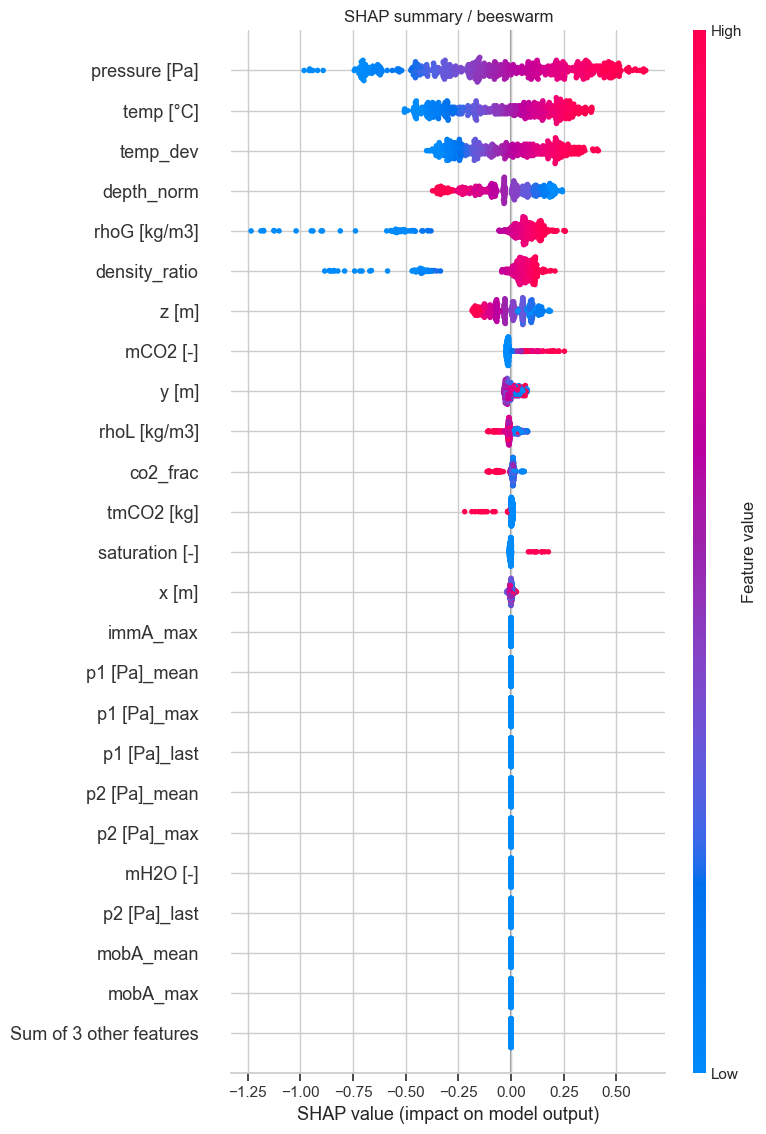

In [24]:
plt.figure(figsize=(8,6))
try:
    shap.plots.beeswarm(shap_values, max_display=25, show=False)
except Exception:
    shap.summary_plot(shap_values, features=X_test_scaled[:shap_values.shape[0]], feature_names=feature_names, show=False)
plt.title("SHAP summary / beeswarm")
plt.tight_layout()
plt.savefig("shap_beeswarm.png", dpi=300, bbox_inches="tight")
plt.show()

## 5. SHAP — Local Feature Attribution for the Most Mis-Predicted Sample

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


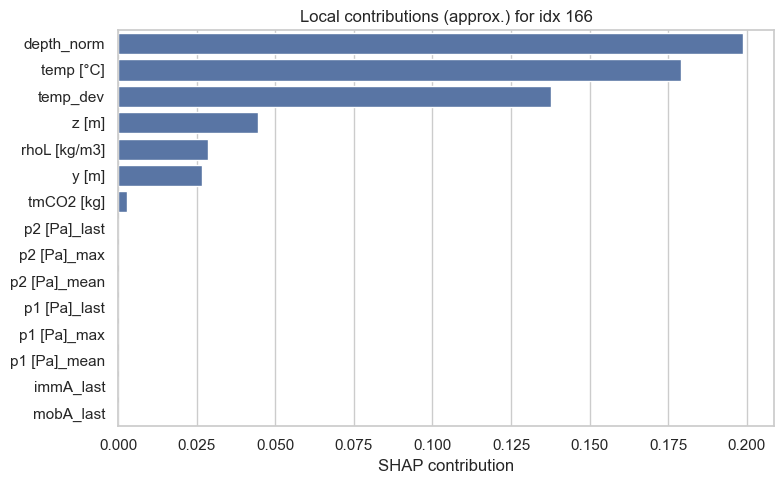

In [32]:
residuals = y_test - y_pred

worst_idx = np.argmax(np.abs(residuals))
sample = X_test_scaled[worst_idx:worst_idx+1]

plt.figure(figsize=(8,5))
try:
    shap.plots.waterfall(expl(sample), show=False)
    plt.title(f"SHAP waterfall for test index {worst_idx} (largest abs residual)")
except Exception:
    # fallback: summary of contributions
    vals = shap_values[worst_idx].values if hasattr(shap_values[worst_idx], 'values') else shap_values[0][worst_idx]
    contrib = pd.Series(vals, index=feature_names).sort_values(ascending=False)[:15]

sns.barplot(x=contrib.values, y=contrib.index)
plt.title(f"Local contributions (approx.) for idx {worst_idx}")
plt.xlabel("SHAP contribution")
plt.ylabel("")
plt.tight_layout()
plt.savefig("shap_local_waterfall.png", dpi=300, bbox_inches="tight")
plt.show()

## 6. SHAP-Driven Ranking of Input Features for Subsequent PDP Analysis

In [28]:
try:
    # shap_values may be an array or object
    if hasattr(shap_values, 'values'):
        arr = shap_values.values
    else:
        arr = np.array(shap_values)
    mean_abs = np.mean(np.abs(arr), axis=0)
    top_idx = np.argsort(mean_abs)[::-1][:6].tolist()
except Exception:
    # fallback manual selection (example: depth_norm, co2_frac, saturation, density_ratio, temp_dev, p1 [Pa]_last)
    name_to_idx = {n: i for i, n in enumerate(feature_names)}
    fallback = ['depth_norm', 'co2_frac', 'saturation [-]', 'density_ratio', 'temp_dev', 'p1 [Pa]_last']
    top_idx = [name_to_idx[n] for n in fallback if n in name_to_idx][:6]

top_feature_names = [feature_names[i] for i in top_idx]
print("Top features for PDP:", top_feature_names)

Top features for PDP: ['pressure [Pa]', 'temp [°C]', 'temp_dev', 'depth_norm', 'rhoG [kg/m3]', 'density_ratio']


In [50]:
class PDPRegressor:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        y = self.model.predict(X, verbose=0)
        return y.reshape(-1)

    def fit(self, X, y=None):
        return self  # do nothing, already trained

    # sklearn's new fitted check
    def __sklearn_is_fitted__(self):
        return True

In [51]:
pdp_model = PDPRegressor(mlp)
pdp_model.n_features_in_ = X_test_scaled.shape[1]


PDP grid v1:   0%|          | 0/30 [00:00<?, ?it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


PDP grid v1:   3%|▎         | 1/30 [00:03<01:52,  3.87s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


PDP grid v1:   7%|▋         | 2/30 [00:07<01:43,  3.71s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


PDP grid v1:  10%|█         | 3/30 [00:11<01:38,  3.63s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


PDP grid v1:  13%|█▎        | 4/30 [00:14<01:33,  3.61s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


PDP grid v1:  17%|█▋        | 5/30 [00:18<01:29,  3.60s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


PDP grid v1:  20%|██        | 6/30 [00:21<01:26,  3.61s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


PDP grid v1:  23%|██▎       | 7/30 [00:25<01:22,  3.60s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


PDP grid v1:  27%|██▋       | 8/30 [00:29<01:20,  3.65s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


PDP grid v1:  30%|███       | 9/30 [00:33<01:18,  3.73s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


PDP grid v1:  33%|███▎      | 10/30 [00:36<01:13,  3.66s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


PDP grid v1:  37%|███▋      | 11/30 [00:40<01:09,  3.67s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


PDP grid v1:  40%|████      | 12/30 [00:44<01:06,  3.71s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


PDP grid v1:  43%|████▎     | 13/30 [00:47<01:02,  3.68s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


PDP grid v1:  47%|████▋     | 14/30 [00:51<00:58,  3.66s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


PDP grid v1:  50%|█████     | 15/30 [00:54<00:54,  3.63s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


PDP grid v1:  53%|█████▎    | 16/30 [00:58<00:50,  3.63s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


PDP grid v1:  57%|█████▋    | 17/30 [01:02<00:47,  3.63s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


PDP grid v1:  60%|██████    | 18/30 [01:05<00:43,  3.63s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


PDP grid v1:  63%|██████▎   | 19/30 [01:09<00:39,  3.62s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


PDP grid v1:  67%|██████▋   | 20/30 [01:12<00:36,  3.63s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


PDP grid v1:  70%|███████   | 21/30 [01:16<00:32,  3.59s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


PDP grid v1:  73%|███████▎  | 22/30 [01:20<00:29,  3.64s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


PDP grid v1:  77%|███████▋  | 23/30 [01:23<00:25,  3.60s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


PDP grid v1:  80%|████████  | 24/30 [01:27<00:22,  3.68s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


PDP grid v1:  83%|████████▎ | 25/30 [01:31<00:18,  3.73s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


PDP grid v1:  87%|████████▋ | 26/30 [01:35<00:14,  3.69s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


PDP grid v1:  90%|█████████ | 27/30 [01:38<00:11,  3.73s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


PDP grid v1:  93%|█████████▎| 28/30 [01:42<00:07,  3.70s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


PDP grid v1:  97%|█████████▋| 29/30 [01:46<00:03,  3.82s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


PDP grid v1: 100%|██████████| 30/30 [01:50<00:00,  3.67s/it]


<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

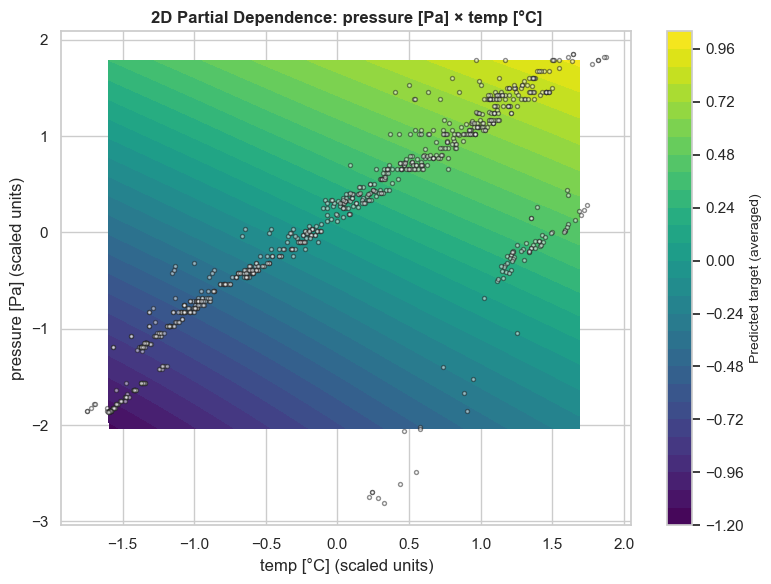

In [ ]:
from tqdm import tqdm 

def compute_2d_pdp(model_predict, X, f1, f2,
                   grid_resolution=30, subsample=400,
                   sample_random_state=42):

    rng = np.random.RandomState(sample_random_state)
    n = X.shape[0]
    if subsample is None:
        X_sub = X
    else:
        subsample = min(subsample, n)
        idx = rng.choice(n, size=subsample, replace=False)
        X_sub = X[idx].copy()

    v1_min, v1_max = np.percentile(X[:, f1], [1, 99])
    v2_min, v2_max = np.percentile(X[:, f2], [1, 99])
    v1_vals = np.linspace(v1_min, v1_max, grid_resolution)
    v2_vals = np.linspace(v2_min, v2_max, grid_resolution)

    Z = np.zeros((grid_resolution, grid_resolution), dtype=np.float64)

    for i, v1 in enumerate(tqdm(v1_vals, desc="PDP grid v1")):
        for j, v2 in enumerate(v2_vals):
            X_tmp = X_sub.copy()
            X_tmp[:, f1] = v1
            X_tmp[:, f2] = v2
            Z[i, j] = preds.mean()
   
    Xg, Yg = np.meshgrid(v2_vals, v1_vals) 
    return Xg, Yg, Z, v1_vals, v2_vals

def plot_2d_pdp(Xg, Yg, Z, v1_vals, v2_vals, f1_name, f2_name,
                X_samples=None, f1_samples=None, f2_samples=None,
                feature_scaler=None, invert_scale=False,
                cmap="viridis", outfile="pdp_2d_interaction.png"):
    
    fig, ax = plt.subplots(figsize=(8,6))
    cf = ax.contourf(Xg, Yg, Z, levels=30, cmap=cmap)
    cbar = fig.colorbar(cf, ax=ax)
    cbar.set_label("Predicted target (averaged)", fontsize=10)
    ax.set_xlabel(f"{f2_name} (scaled units)")
    ax.set_ylabel(f"{f1_name} (scaled units)")
    ax.set_title(f"2D Partial Dependence: {f1_name} × {f2_name}", fontsize=12, weight="bold")

    if X_samples is not None:
        ax.scatter(X_samples[:, np.where(v2_vals==v2_vals[0])[0][0] if False else f2_idx],
                   X_samples[:, f1_idx], s=8, alpha=0.5, color="white", edgecolor="k")

    if feature_scaler is not None and invert_scale:
        n_ticks = 5
        x_ticks = np.linspace(v2_vals.min(), v2_vals.max(), n_ticks)
        y_ticks = np.linspace(v1_vals.min(), v1_vals.max(), n_ticks)

        try:
            base = np.zeros((1, feature_scaler.scale_.shape[0]))
            base[:] = feature_scaler.mean_
            inv_x = []
            for xt in x_ticks:
                v = base.copy()
                v[0, f2_idx] = xt
                inv = feature_scaler.inverse_transform(v)[0, f2_idx]
                inv_x.append(inv)
            inv_y = []
            for yt in y_ticks:
                v = base.copy()
                v[0, f1_idx] = yt
                inv = feature_scaler.inverse_transform(v)[0, f1_idx]
                inv_y.append(inv)
            ax.set_xticks(x_ticks)
            ax.set_xticklabels([f"{val:.2f}" for val in inv_x])
            ax.set_yticks(y_ticks)
            ax.set_yticklabels([f"{val:.2f}" for val in inv_y])
            ax.set_xlabel(f"{f2_name} (original units)")
            ax.set_ylabel(f"{f1_name} (original units)")
        except Exception:
            pass

    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()


f1_idx = top_idx[0]
f2_idx = top_idx[1]
f1_name = feature_names[f1_idx]
f2_name = feature_names[f2_idx]

def model_predict_callable(X_batch):
    return wrapped_mlp.predict(X_batch)

Xg, Yg, Z, v1_vals, v2_vals = compute_2d_pdp(
    model_predict=model_predict_callable,
    X=X_test_scaled,
    f1=f1_idx,
    f2=f2_idx,
    grid_resolution=30,
    subsample=300
)

plot_2d_pdp(Xg, Yg, Z, v1_vals, v2_vals, f1_name, f2_name,
            X_samples=X_test_scaled, invert_scale=False,
            feature_scaler=None, outfile="pdp_2d_interaction_manual.png")
